## Local PnyxDB Log Analysis

Parse client/replica logs to derive latency and throughput metrics.


In [126]:
from pathlib import Path
import re
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')


In [127]:
# Configuration
LOG_DIR = Path('../logs')
CLIENT_ID = 0
REPLICA_IDS = [0]

client_log = LOG_DIR / f'client{CLIENT_ID}.log'
replica_logs = [LOG_DIR / f'replica{idx}.log' for idx in REPLICA_IDS]
client_log, replica_logs


(PosixPath('../logs/client0.log'), [PosixPath('../logs/replica0.log')])

### Helpers


In [128]:
ANSI_ESCAPE = re.compile(r'\[[0-9;]*[A-Za-z]')
UUID_RE = re.compile(r'^[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{12}$')
CLIENT_REQ_RE = re.compile(r'(?:\[(?P<ts_bracket>[^\]]+)\]|(?P<ts_plain>\d{4}-[^\s]+)) Client request: (?P<op>\w+) (?P<key>\S+)(?: (?P<data>.*))?')
COMMIT_RE = re.compile(r'^(?P<ts>\d{4}-\d{2}-\d{2}T[^	]+)	.*Committed\s+\{"uuid": "(?P<uuid>[^"]+)"')

def normalize_ts(ts: str) -> str:
    ts = ts.strip()
    if len(ts) > 5 and ts[-5] in '+-':
        return ts[:-5] + ts[-5:-2] + ':' + ts[-2:]
    return ts

def parse_ts(ts: str) -> datetime:
    return datetime.fromisoformat(normalize_ts(ts))

def parse_client_events(path: Path) -> pd.DataFrame:
    events = []
    pending = None
    with path.open() as f:
        for raw in f:
            line = raw.strip()
            m = CLIENT_REQ_RE.match(line)
            if m:
                ts = m.group('ts_bracket') or m.group('ts_plain')
                pending = {
                    'uuid': None,
                    'op': m.group('op'),
                    'key': m.group('key'),
                    'data': m.group('data'),
                    'send_ts': parse_ts(ts),
                }
                continue
            if pending and UUID_RE.match(line):
                pending['uuid'] = line
                events.append(pending)
                pending = None
    df = pd.DataFrame(events)
    if df.empty:
        return pd.DataFrame(columns=['uuid', 'op', 'key', 'data', 'send_ts'])
    return df.dropna(subset=['uuid'])

def parse_commits(paths) -> pd.DataFrame:
    commits = []
    for path in paths:
        with path.open() as f:
            for raw in f:
                line = ANSI_ESCAPE.sub('', raw).strip()
                m = COMMIT_RE.match(line)
                if not m:
                    continue
                commits.append({
                    'uuid': m.group('uuid'),
                    'commit_ts': parse_ts(m.group('ts')),
                    'source': path.name,
                })
    df = pd.DataFrame(commits)
    if df.empty:
        return df
    df = df.sort_values('commit_ts').drop_duplicates('uuid', keep='first')
    return df



In [129]:
client_df = parse_client_events(client_log)
replica_df = parse_commits(replica_logs)
client_df.head()


,uuid,op,key,data,send_ts
0,bf992852-b0ee-4c83-a82a-ebce25a35b29,SET,counter,1,2025-11-26 08:02:48.709000+00:00
1,a7201811-07ac-471e-8c86-e06070a1120f,ADD,counter,1,2025-11-26 08:02:48.715000+00:00
2,e2560048-bb70-4f40-a6d6-077a75a9d9f3,ADD,counter,1,2025-11-26 08:02:48.727000+00:00
3,92a0539a-f8e8-4432-8ac0-c150e2b8ccaf,ADD,counter,1,2025-11-26 08:02:48.738000+00:00
4,5bdcc5ba-178d-4fdf-9630-c375ee2447fb,ADD,counter,1,2025-11-26 08:02:48.749000+00:00


In [130]:
replica_df.head()


,uuid,commit_ts,source
0,bf992852-b0ee-4c83-a82a-ebce25a35b29,2025-11-26 08:02:48.767000+00:00,replica0.log
1,8443667d-bb3b-49e9-a58e-bb837d5be6b0,2025-11-26 08:02:48.827000+00:00,replica0.log
2,62741447-5c1a-4dc6-b56a-8960cff6b9bc,2025-11-26 08:02:48.839000+00:00,replica0.log
3,92a0539a-f8e8-4432-8ac0-c150e2b8ccaf,2025-11-26 08:02:48.840000+00:00,replica0.log
4,a7201811-07ac-471e-8c86-e06070a1120f,2025-11-26 08:02:48.842000+00:00,replica0.log


In [131]:
summary = pd.merge(client_df, replica_df, on='uuid', how='inner')
summary['latency_ms'] = (summary['commit_ts'] - summary['send_ts']).dt.total_seconds() * 1000
summary[['uuid', 'send_ts', 'commit_ts', 'latency_ms']].head()


,uuid,send_ts,commit_ts,latency_ms
0,bf992852-b0ee-4c83-a82a-ebce25a35b29,2025-11-26 08:02:48.709000+00:00,2025-11-26 08:02:48.767000+00:00,58.0
1,a7201811-07ac-471e-8c86-e06070a1120f,2025-11-26 08:02:48.715000+00:00,2025-11-26 08:02:48.842000+00:00,127.0
2,e2560048-bb70-4f40-a6d6-077a75a9d9f3,2025-11-26 08:02:48.727000+00:00,2025-11-26 08:02:48.853000+00:00,126.0
3,92a0539a-f8e8-4432-8ac0-c150e2b8ccaf,2025-11-26 08:02:48.738000+00:00,2025-11-26 08:02:48.840000+00:00,102.0
4,5bdcc5ba-178d-4fdf-9630-c375ee2447fb,2025-11-26 08:02:48.749000+00:00,2025-11-26 08:02:48.850000+00:00,101.0


### Failed / uncommitted requests

In [132]:
failed_requests = client_df[~client_df['uuid'].isin(replica_df['uuid'])]
failed_count = failed_requests.shape[0]
failed_count


339

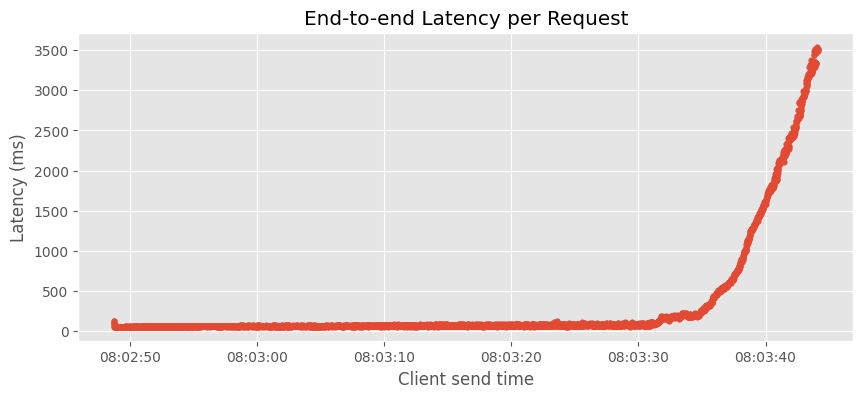

In [133]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(summary['send_ts'], summary['latency_ms'], s=15)
ax.set_xlabel('Client send time')
ax.set_ylabel('Latency (ms)')
ax.set_title('End-to-end Latency per Request')
plt.show()


In [134]:
latency_stats = summary['latency_ms'].describe(percentiles=[0.5,0.95,0.99])
avg_throughput = summary.set_index('commit_ts').resample('1S').size().mean() if not summary.empty else 0
print('Average latency (ms):', latency_stats['mean'])
print('95th percentile latency (ms):', latency_stats.loc['95%'])
print('99th percentile latency (ms):', latency_stats.loc['99%'])
print('Average throughput (req/sec):', avg_throughput)


Average latency (ms): 310.47162904209887
95th percentile latency (ms): 2106.3999999999996
99th percentile latency (ms): 3229.4000000000015
Average throughput (req/sec): 81.95


/tmp/ipykernel_824761/4086126550.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  avg_throughput = summary.set_index('commit_ts').resample('1S').size().mean() if not summary.empty else 0


In [135]:
metrics_table = pd.DataFrame({
    'metric': ['avg_latency_ms', 'p95_latency_ms', 'p99_latency_ms', 'avg_throughput_rps'],
    'value': [
        latency_stats['mean'],
        latency_stats.loc['95%'],
        latency_stats.loc['99%'],
        avg_throughput
    ]
})
metrics_table


,metric,value
0,avg_latency_ms,310.471629
1,p95_latency_ms,2106.400000
2,p99_latency_ms,3229.400000
3,avg_throughput_rps,81.950000


/tmp/ipykernel_824761/3395148108.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  throughput = summary.set_index('commit_ts').resample('1S').size()


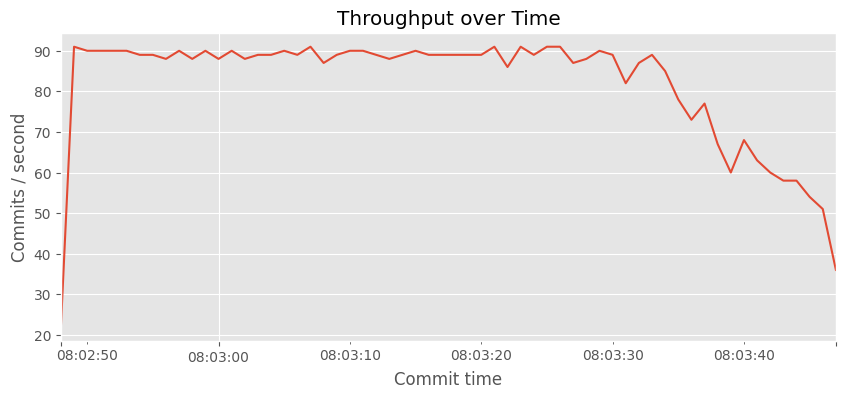

In [136]:
throughput = summary.set_index('commit_ts').resample('1S').size()
fig, ax = plt.subplots(figsize=(10, 4))
throughput.plot(ax=ax)
ax.set_ylabel('Commits / second')
ax.set_xlabel('Commit time')
ax.set_title('Throughput over Time')
plt.show()
